# 🦄 가랏, 몬스터볼! 전설의 포켓몬 찾아 삼만리

## 개요 및 목차
### 개요
- 목표 : 포켓몬 데이터 셋에서 전설의 포켓몬을 찾는 모델 만들기, 모델의 성능을 최대한 향상 시키기 (캐글 데이터셋)
    
### 목차 및 설계
**1. 포켓몬 데이터 불러오기**
- 라이브러리 가져오기
- 데이터셋을 pandas로 불러오기
- 전설의 포켓몬 데이터 확인하기

**2. EDA**
- 2-1. 전설의 포켓몬 살펴보기
    - 결측치 처리 및 전체 데이터 이해하기
    - 각 컬럼 이해하기 
        - ID와 이름 : unique 여부 확인
        - 포켓몬의 속성 : Type 1, Type 2 내 속성의 종류/개수/데이터 분포 등
        - Total 값과 6개 stats의 총합이 같은지 확인, Total 값에 따른 Legendary의 분포
        - 세부 stats(6개) : 각각의 분포 및 분석
        - 세대 : 세대 별 분포
- 2-2. 전설의 포켓몬 vs 일반 포켓몬 차이점(비교) : 전설의 포켓몬을 일반 포켓몬에서 분류해낼 목적으로
    - Total값 : 전설/일반 포켓몬의 Total값, Total값에 대한 포켓몬 수 등을 통한 인사이트
    - 이름 : 특정 단어의 포함 여부, 긴 이름 등을 통한 인사이트

**3. 데이터 전처리**
- 이름의 길이가 10 이상인가?
- 토큰 추출 : 전설의 포켓몬에서 많이 등장하는 토큰 추리기, 토큰 포함 여부를 원-핫 인코딩으로 처리

**4. 모델 학습**
- 베이스라인 만들기
- 의사 결정 트리 모델 학습시키기
- 피쳐 엔지니어링 데이터로 학습
- 의사 결정 트리 모델 다시 학습시키기

**5. 회고**
- KEEP
- PROBLEM
- TRY

**6. Reference**
- 캐글 포켓몬 데이터셋
- 판다스 데이터프레임, 문법
- 정규표현식
- apply() 함수
- Counter 객체
- Confusion Matrix

---

## 1. 포켓몬 데이터 불러오기
### 라이브러리 가져오기

In [328]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
print('슝=3')

슝=3


### 데이터셋을 pandas로 불러오기

In [329]:
import os
csv_path = os.getenv("HOME") +"/aiffel/pokemon_eda/data/Pokemon.csv"
original_data = pd.read_csv(csv_path)
print('슝=3')

슝=3


In [330]:
# 데이터 사본 생성
pokemon = original_data.copy()
print(pokemon.shape)
pokemon.head()

(800, 13)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


### 확인할 데이터는 Legendary (전설의 포켓몬인지 아닌지의 여부)

In [331]:
# 전설의 포켓몬 데이터셋
legendary = pokemon[pokemon["Legendary"] == True].reset_index(drop=True)
print(legendary.shape)
legendary.head()

(65, 13)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,144,Articuno,Ice,Flying,580,90,85,100,95,125,85,1,True
1,145,Zapdos,Electric,Flying,580,90,90,85,125,90,100,1,True
2,146,Moltres,Fire,Flying,580,90,100,90,125,85,90,1,True
3,150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True
4,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,106,190,100,154,100,130,1,True


In [332]:
# Q. 일반 포켓몬의 데이터셋도 만들어봅시다.
ordinary = pokemon[pokemon["Legendary"] == False].reset_index(drop=True)
print(ordinary.shape)
ordinary.head()

(735, 13)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


## 2. EDA
## 2-1. 전설의 포켓몬 살펴보기
### (1) 결측치와 전체 칼럼

In [333]:
# 결측치 확인
pokemon.isnull().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [334]:
# 전체 컬럼 이해하기
print(len(pokemon.columns))
pokemon.columns

13


Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

In [335]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


### (2) ID와 이름

In [336]:
# # : ID number
len(set(pokemon["#"]))

721

In [337]:
# 전체 데이터는 총 800개인데 #컬럼을 집합으로 만든 자료형은 그보다 작은 721개의 데이터
# 집합의 크기가 800이 아니라 721이므로 # 컬럼의 값은 unique하지 않으며(index로 쓸 수 없으며), 같은 번호를 가지는 컬럼들이 있음
# (파이썬의 집합 set 자료형은 중복 데이터를 가질 수 없으므로)

In [338]:
# 같은 #값을 가지는 포켓몬 확인 (ex.#6)
pokemon[pokemon["#"] == 6]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False


In [339]:
# Name : 이름

# Q. 총 몇 종류의 포켓몬 이름이 있는지 확인해봅시다! -> 800개로 모든 이름은 unique
len(set(pokemon["Name"]))

800

### (3) 포켓몬의 속성
- Type 1 & Type 2 : 포켓몬의 속성

In [340]:
# 무작위로 2마리 살펴보기
pokemon.loc[[6, 10]]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
10,8,Wartortle,Water,NaN,405,59,63,80,65,80,58,1,False


In [341]:
# 각 속성의 종류는 총 몇 가지?

len(list(set(pokemon["Type 1"]))), len(list(set(pokemon["Type 2"])))

(18, 19)

In [342]:
# Type 2가 한 가지 더 많은 것이 무엇인지 확인 -> Type1, 2 모두 같은 세트의 데이터가 들어가 있음

set(pokemon["Type 2"]) - set(pokemon["Type 1"])

{nan}

In [343]:
# 포켓몬들의 모든 Type을 types 변수에 저장

types = list(set(pokemon["Type 1"]))
print(len(types))
print(types)

18
['Fighting', 'Psychic', 'Dark', 'Ground', 'Ghost', 'Water', 'Poison', 'Electric', 'Bug', 'Normal', 'Dragon', 'Rock', 'Flying', 'Steel', 'Grass', 'Fire', 'Fairy', 'Ice']


In [344]:
# Type을 하나만 가지고 있는 포켓몬은 몇 마리? 
 # -> Type 2가 NaN인 포켓몬의 수 구하기
 # -> 데이터가 비어있는 NaN값의 개수를 확인하고 싶을 때는 isna() 함수를 활용

pokemon["Type 2"].isna().sum()

386

- Type 1 데이터 분포 plot
    - 일반 포켓몬보다 전설의 포켓몬 수가 매우 적은 불균형 데이터이기 때문에, 전설의 포켓몬은 따로 시각화해 주는 것이 좋음
    - plt의 subplot을 활용해서 두 개의 그래프를 한 번에 그리면서, 그래프는 sns(seaborn)의 countplot을 활용
    - countplot은 데이터의 개수를 표시하는 플롯

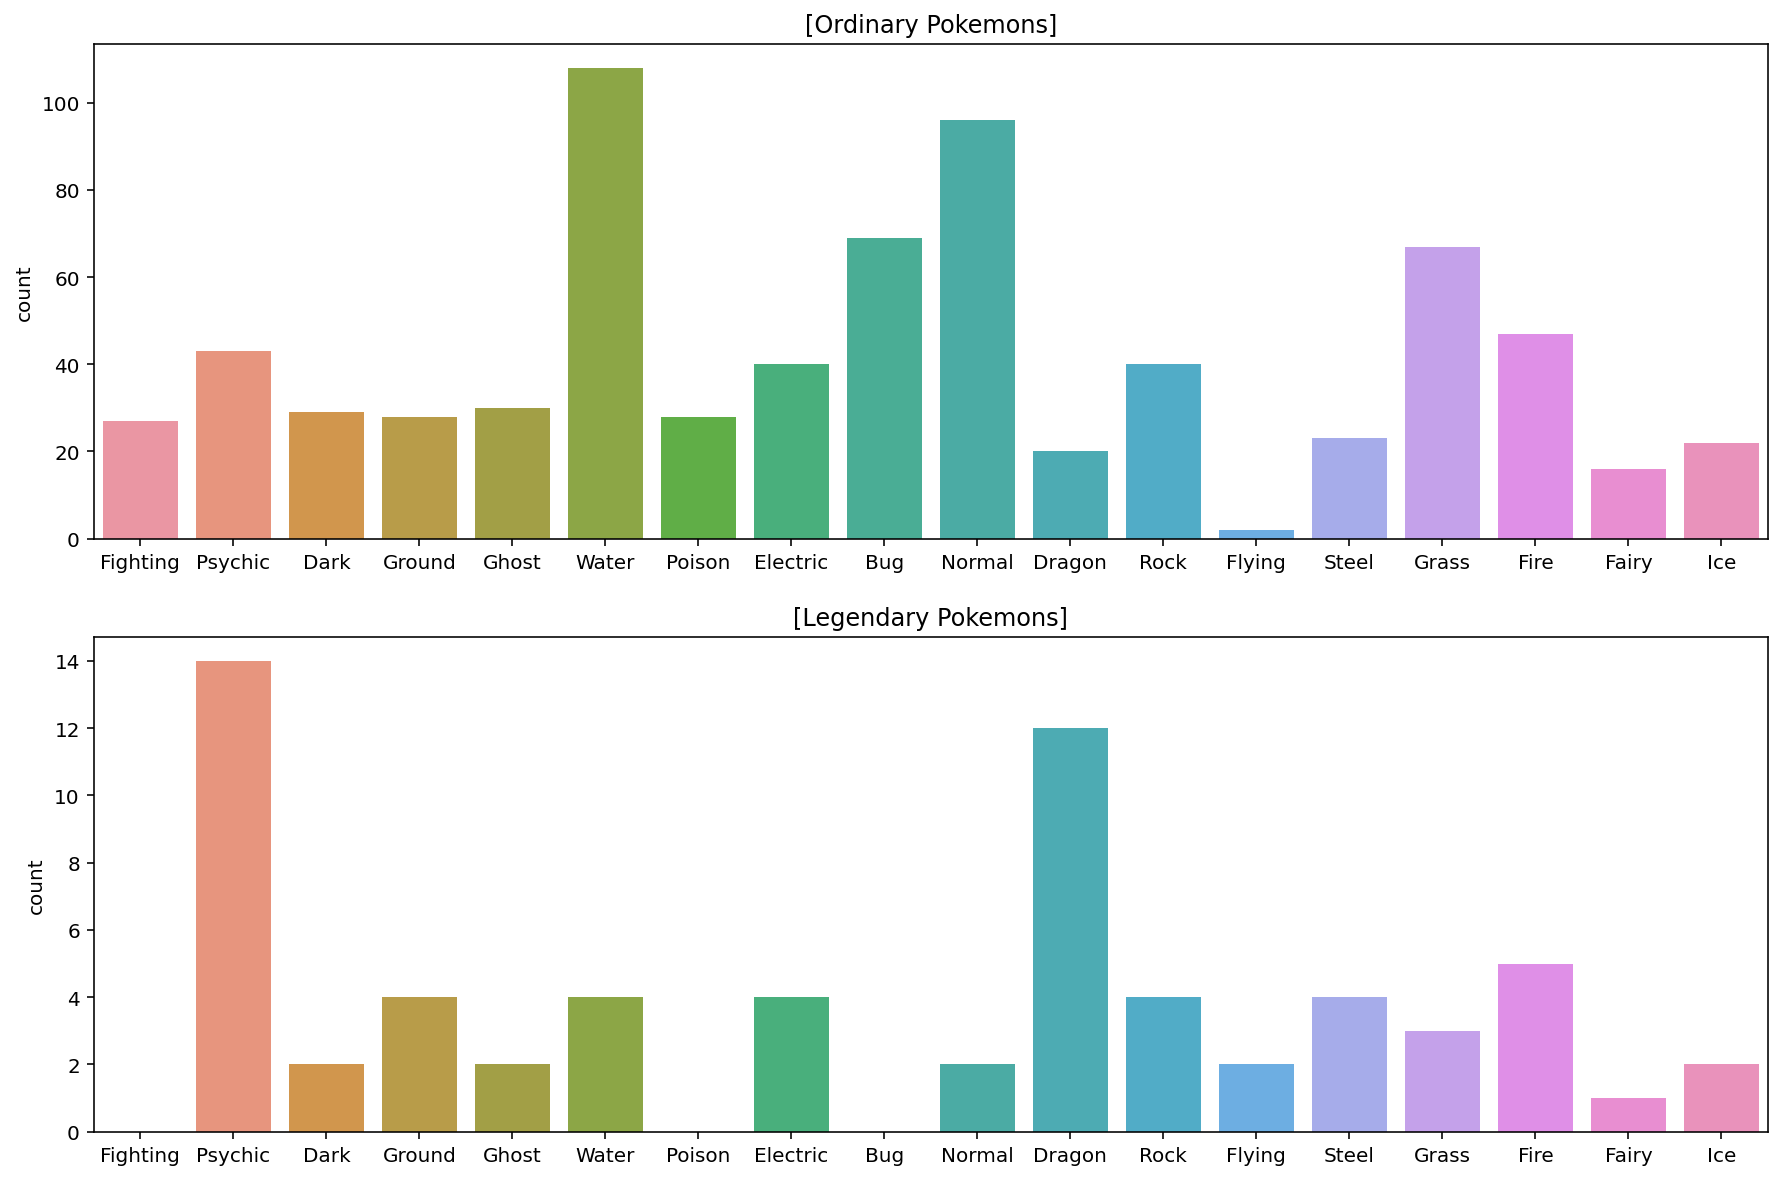

In [345]:
plt.figure(figsize=(15, 10))  # 화면 해상도에 따라 그래프 크기를 조정해 주세요.

plt.subplot(211)
sns.countplot(data=ordinary, x="Type 1", order=types).set_xlabel('')
plt.title("[Ordinary Pokemons]")

plt.subplot(212)
sns.countplot(data=legendary, x="Type 1", order=types).set_xlabel('')
plt.title("[Legendary Pokemons]")

plt.show()

In [346]:
# 그래프로 보는 속성 차이
# - 일반 포켓몬에는 물(Water) 속성, 노말(Normal) 속성, 벌레(Bug) 속성 등이 가장 많음
# - 전설의 포켓몬에는 드래곤(Dragon) 속성, 에스퍼(Psychic) 속성이 가장 많음

In [347]:
# 피벗 테이블(pivot table)로 각 속성에 Legendary 포켓몬들이 몇 퍼센트씩 있는지 확인
 # sort_value를 활용해 높은 것부터 낮은 순으로 정렬
    
# Type1별로 Legendary의 비율을 보여주는 피벗 테이블
pd.pivot_table(pokemon, index="Type 1", values="Legendary").sort_values(by=["Legendary"], ascending=False)

,Legendary
Type 1,
Flying,0.500000
Dragon,0.375000
Psychic,0.245614
Steel,0.148148
Ground,0.125000
Fire,0.096154
Electric,0.090909
Rock,0.090909
Ice,0.083333


In [348]:
# Legendary 비율이 가장 높은 속성은 Flying(50%) -> 날아다니는 포켓몬은 전설의 포켓몬일 확률이 높다.

- Type 2 데이터 분포 plot
    - Type 2에는 NaN(결측값)이 존재. Countplot을 그릴 때는 결측값은 자동으로 제외된다.

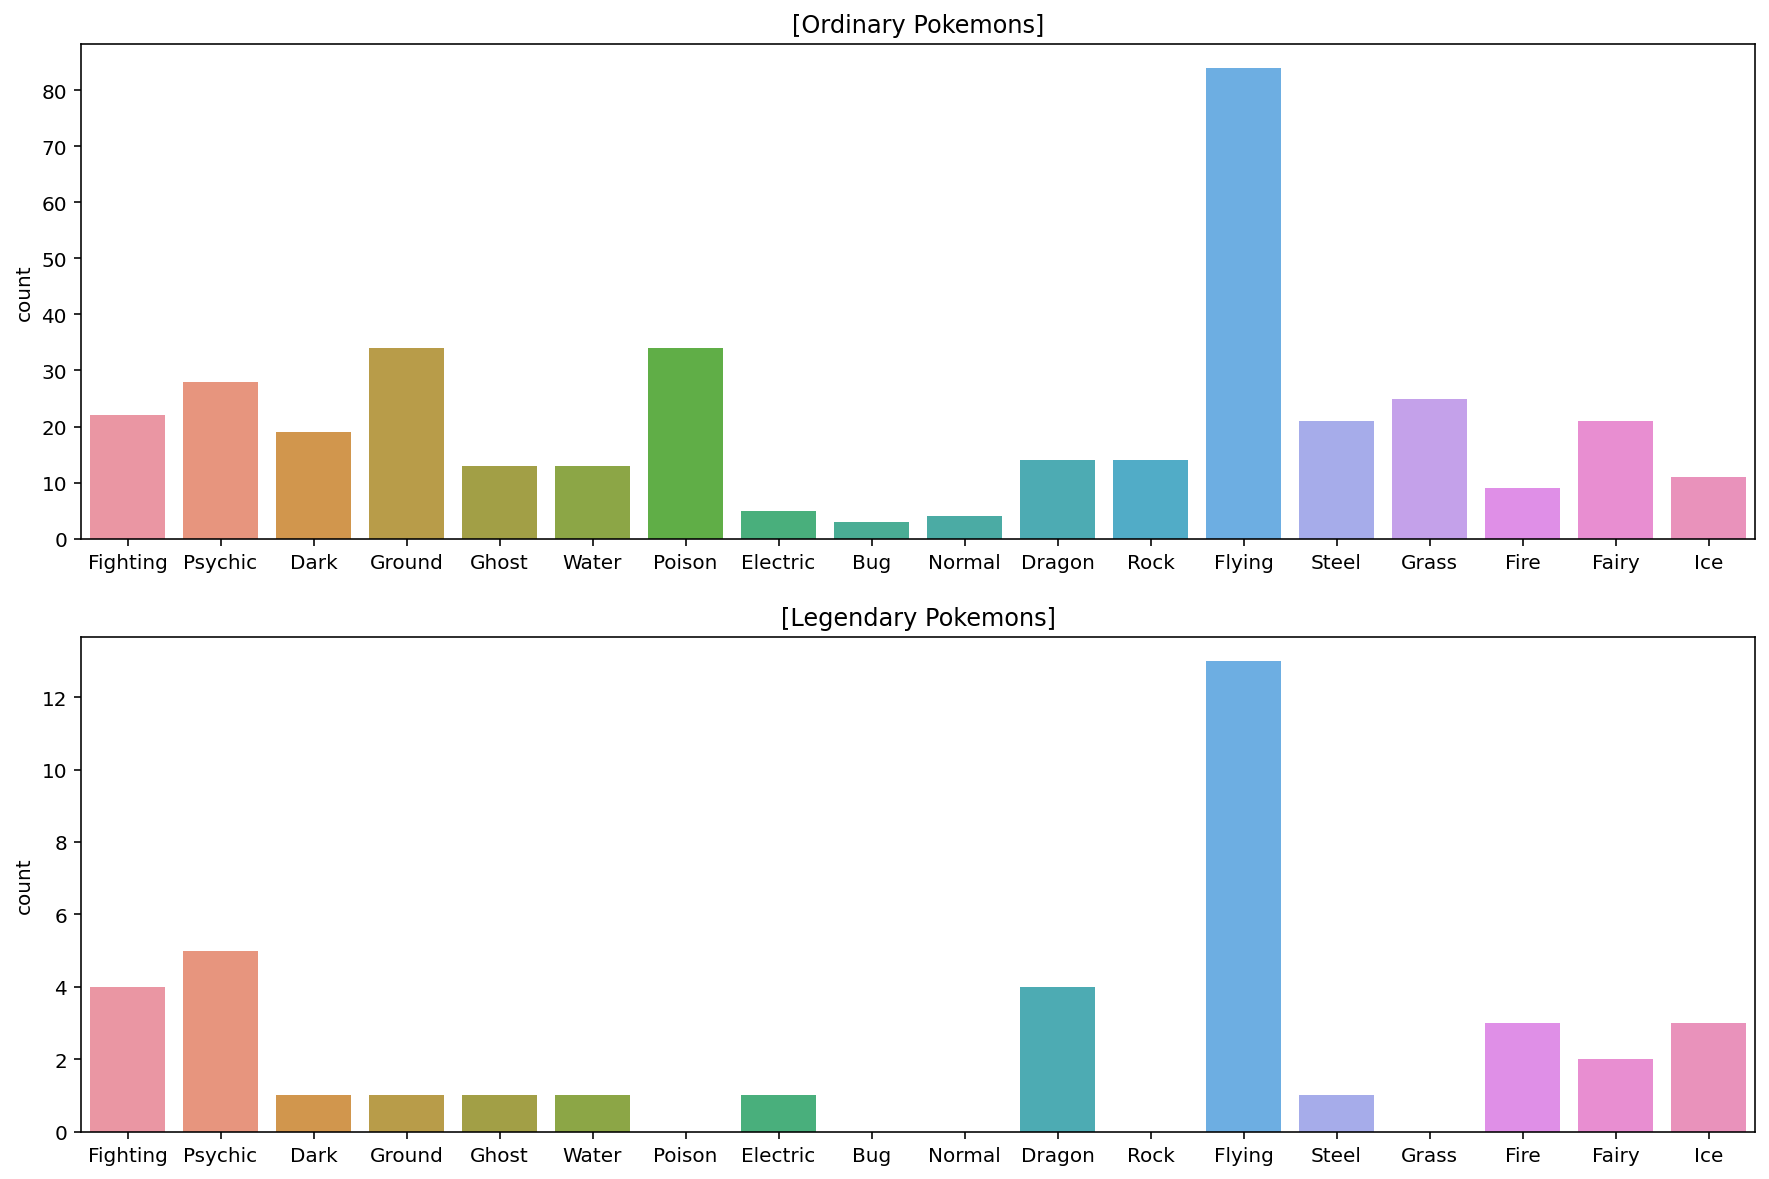

In [349]:
plt.figure(figsize=(15, 10))  # 화면 해상도에 따라 그래프 크기를 조정해 주세요.

plt.subplot(211)
sns.countplot(data=ordinary, x="Type 2", order=types).set_xlabel('')
plt.title("[Ordinary Pokemons]")

plt.subplot(212)
sns.countplot(data=legendary, x="Type 2", order=types).set_xlabel('')
plt.title("[Legendary Pokemons]")

plt.show()

In [350]:
# Flying 둘 다 높음
# 일반에 비해 전설의 포켓몬은 Fighting, Psychic, Dragon 등의 속성이 많음

In [351]:
# Q. Type 2에 대해서도 피벗 테이블을 만들어봅시다.
pd.pivot_table(pokemon, index="Type 2", values="Legendary").sort_values(by=["Legendary"], ascending=False)

,Legendary
Type 2,
Fire,0.250000
Dragon,0.222222
Ice,0.214286
Electric,0.166667
Fighting,0.153846
Psychic,0.151515
Flying,0.134021
Fairy,0.086957
Water,0.071429


In [352]:
# Type 2에서는 Fire 속성 포켓몬의 Legendary 비율이 25%로 가장 높다.

### (4) 모든 스탯의 총합
- Total : 모든 스탯의 총합
    - 포켓몬은 총 6가지의 스탯 값을 가지며, 이 6가지 속성값의 총합이 Total 컬럼

In [353]:
stats = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]
stats

['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

In [354]:
# 실제로 6개 스탯의 총합과 데이터에 제공된 Total값이 맞는지 확인 - 1번째 포켓몬으로 검증

print("#0 pokemon: ", pokemon.loc[0, "Name"])
print("total: ", int(pokemon.loc[0, "Total"]))
print("stats: ", list(pokemon.loc[0, stats]))
print("sum of all stats: ", sum(list(pokemon.loc[0, stats])))

#0 pokemon:  Bulbasaur
total:  318
stats:  [45, 49, 49, 65, 65, 45]
sum of all stats:  318


In [355]:
# 전체 포켓몬에 대해 Total 값이 stats의 총합과 같은지 확인
 # pokemon['Total'].values와 pokemon[stats].values들의 총합이 같은 포켓몬의 개수를 sum으로 확인
 # stats의 경우에는 포켓몬마다 가로 방향으로 더해야 하기 때문에 axis=1이 들어가야함!
    
print("total: ", int(sum(pokemon['Total'].values)))
print("sum of all stats: ", int(sum(pokemon[stats].values.sum(axis=1))))

pokemon_count = int(sum(pokemon['Total'].values == pokemon[stats].values.sum(axis=1)))
print("pokemon_count_total=stats: ", pokemon_count)

total:  348082
sum of all stats:  348082
pokemon_count_total=stats:  800


---
시행착오

In [356]:
print("sum of all stats: ", sum(pokemon[stats].values.axis=1))
# 가로로 더한 뒤, 그것의 합계가 필요한데 오류 발생

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (187562867.py, line 1)

In [357]:
print("sum of all stats: ", sum(pokemon[stats].values.sum(axis=1)))

# 가로로 합계를 먼저 구해주고 -> 그것의 총합으로 해결
# int형으로 반영하여 최종 코드에 반영함

sum of all stats:  348082


In [358]:
len(pokemon['Total'].values == pokemon[stats].values.sum(axis=1))
# 조건을 만족 여부(True/False)의 개수라 포켓몬의 개수가 아님

800

In [359]:
sum(pokemon['Total'].values == pokemon[stats].values.sum(axis=1))
# 포켓몬의 개수 확인 완료

800

---

- Total값에 따른 분포 plot
    - Total 값과 Legendary 는 어떤 관계가 있을지 확인
    - Legendary 여부에 따라 색깔(hue) 다르게 설정
    - -> Type 1 별로 Total 값을 확인했을 때, 전설의 포켓몬은 주로 Total 스탯 값이 높다

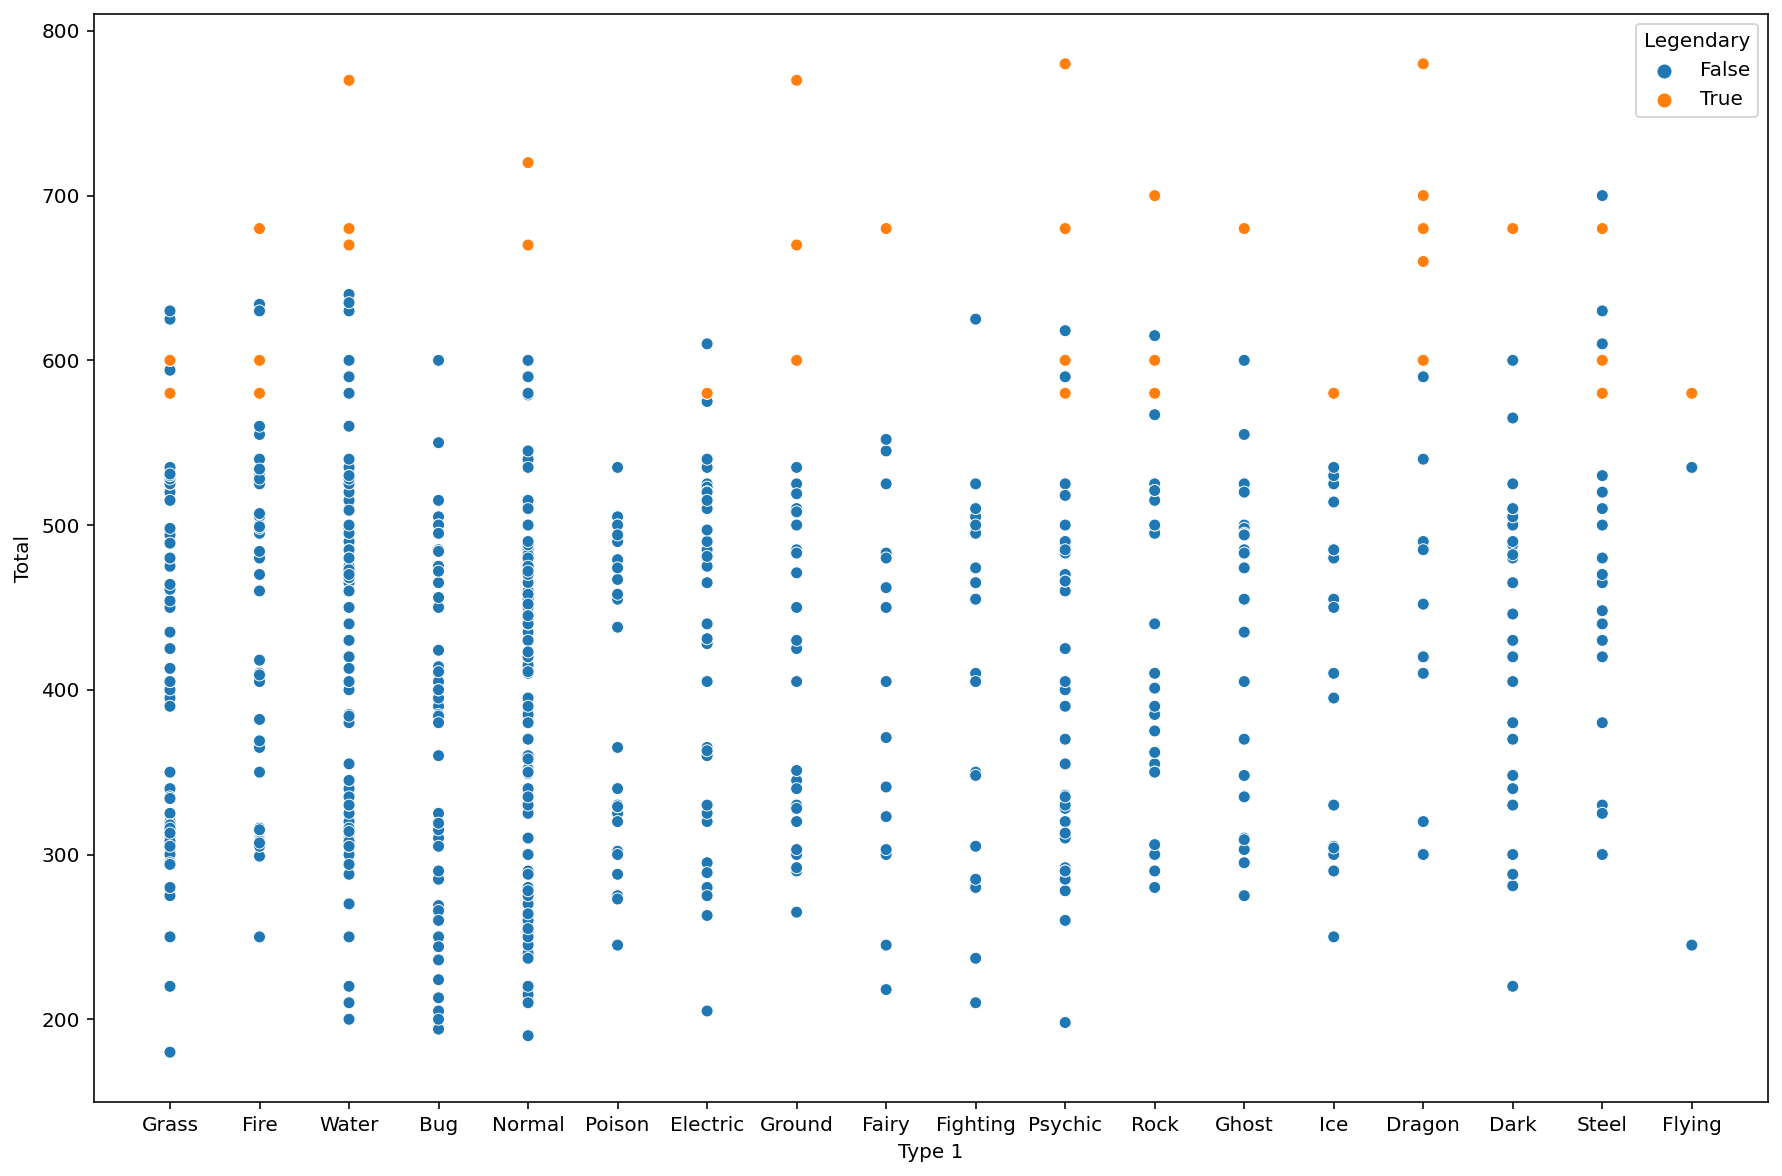

In [360]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10) 

sns.scatterplot(data=pokemon, x="Type 1", y="Total", hue="Legendary")
plt.show()

### (5) 세부 스탯
- 세부스탯: HP, Attack, Defense, Sp. Atk, Sp. Def, Speed
    - 각각의 스탯 값은 어떻게 분포되어 있을지? subplot으로 여러 그래프를 한 번에 확인

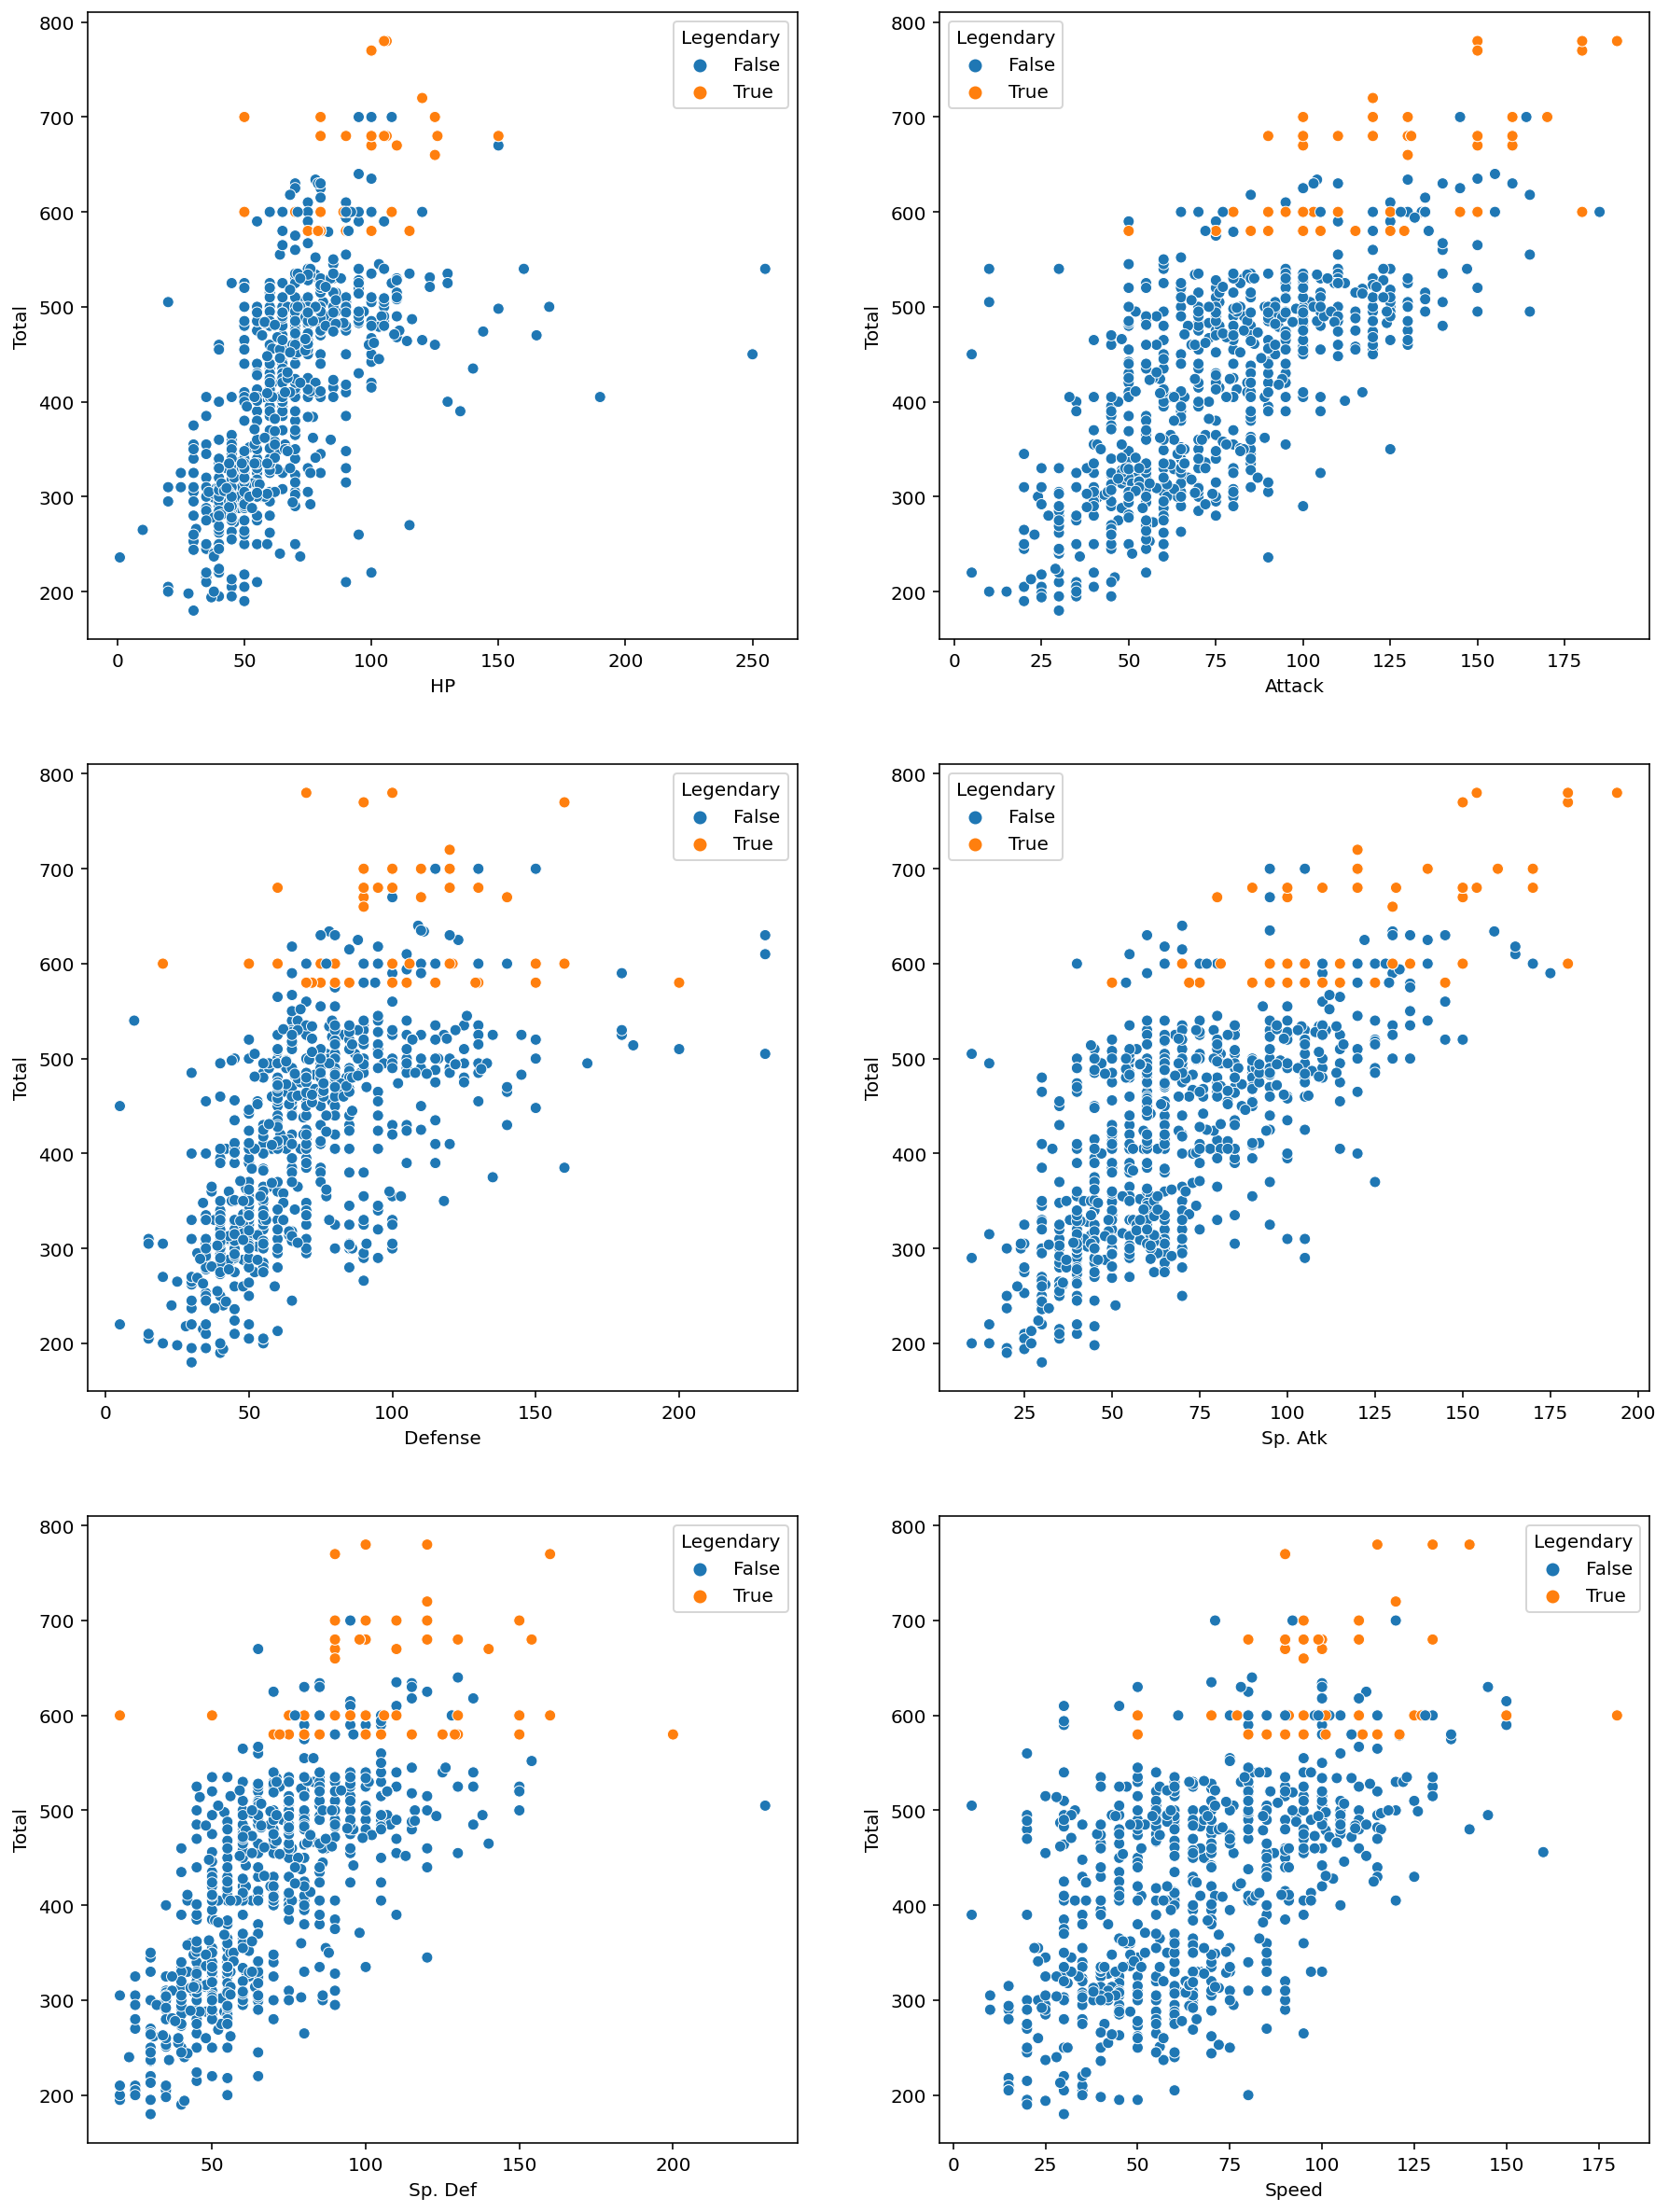

In [361]:
# 각각의 스탯에 대한 scatter plot을 6개의 subplot으로 표현합니다.

figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)
figure.set_size_inches(15, 21)  # 화면 해상도에 따라 그래프 크기를 조정해 주세요.

# "HP" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="HP", hue="Legendary", ax=ax1)

# "Attack" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Attack", hue="Legendary", ax=ax2)

# "Defense" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Defense", hue="Legendary", ax=ax3)

# "Sp. Atk" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Sp. Atk", hue="Legendary", ax=ax4)

# "Sp. Def" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Sp. Def", hue="Legendary", ax=ax5)

# "Speed" 스탯의 scatter plot
sns.scatterplot(data=pokemon, y="Total", x="Speed", hue="Legendary", ax=ax6)

plt.show()

- 각 스탯 분석
    - HP, Defense, Sp. Def
        - 전설의 포켓몬은 주로 높은 스탯을 가짐. 
        - 그러나 이 스탯에서는 일반 포켓몬이 더 높은 경우가 몇몇 있다._(150~)200 넘는 경우
        - -> 이 경우의 일반 포켓몬의 Total값이 특별히 높지는 않아서, 특정 스탯이 강력한 특화형 포켓몬으로 보임
    - Attack, Sp. Atk, Speed
        - total과 거의 비례함
        - 전설의 포켓몬이 각 스탯의 최대치를 차지하고 있음

### (6) 세대
- Generation : 포켓몬의 세대
    - Generation은 각 포켓몬의 "세대"로, 현재 데이터셋에는 1~6세대의 포켓몬이 존재
    - 전설의 포켓몬은 3세대부터 많아졌다가 6세대 때 줄어듦.

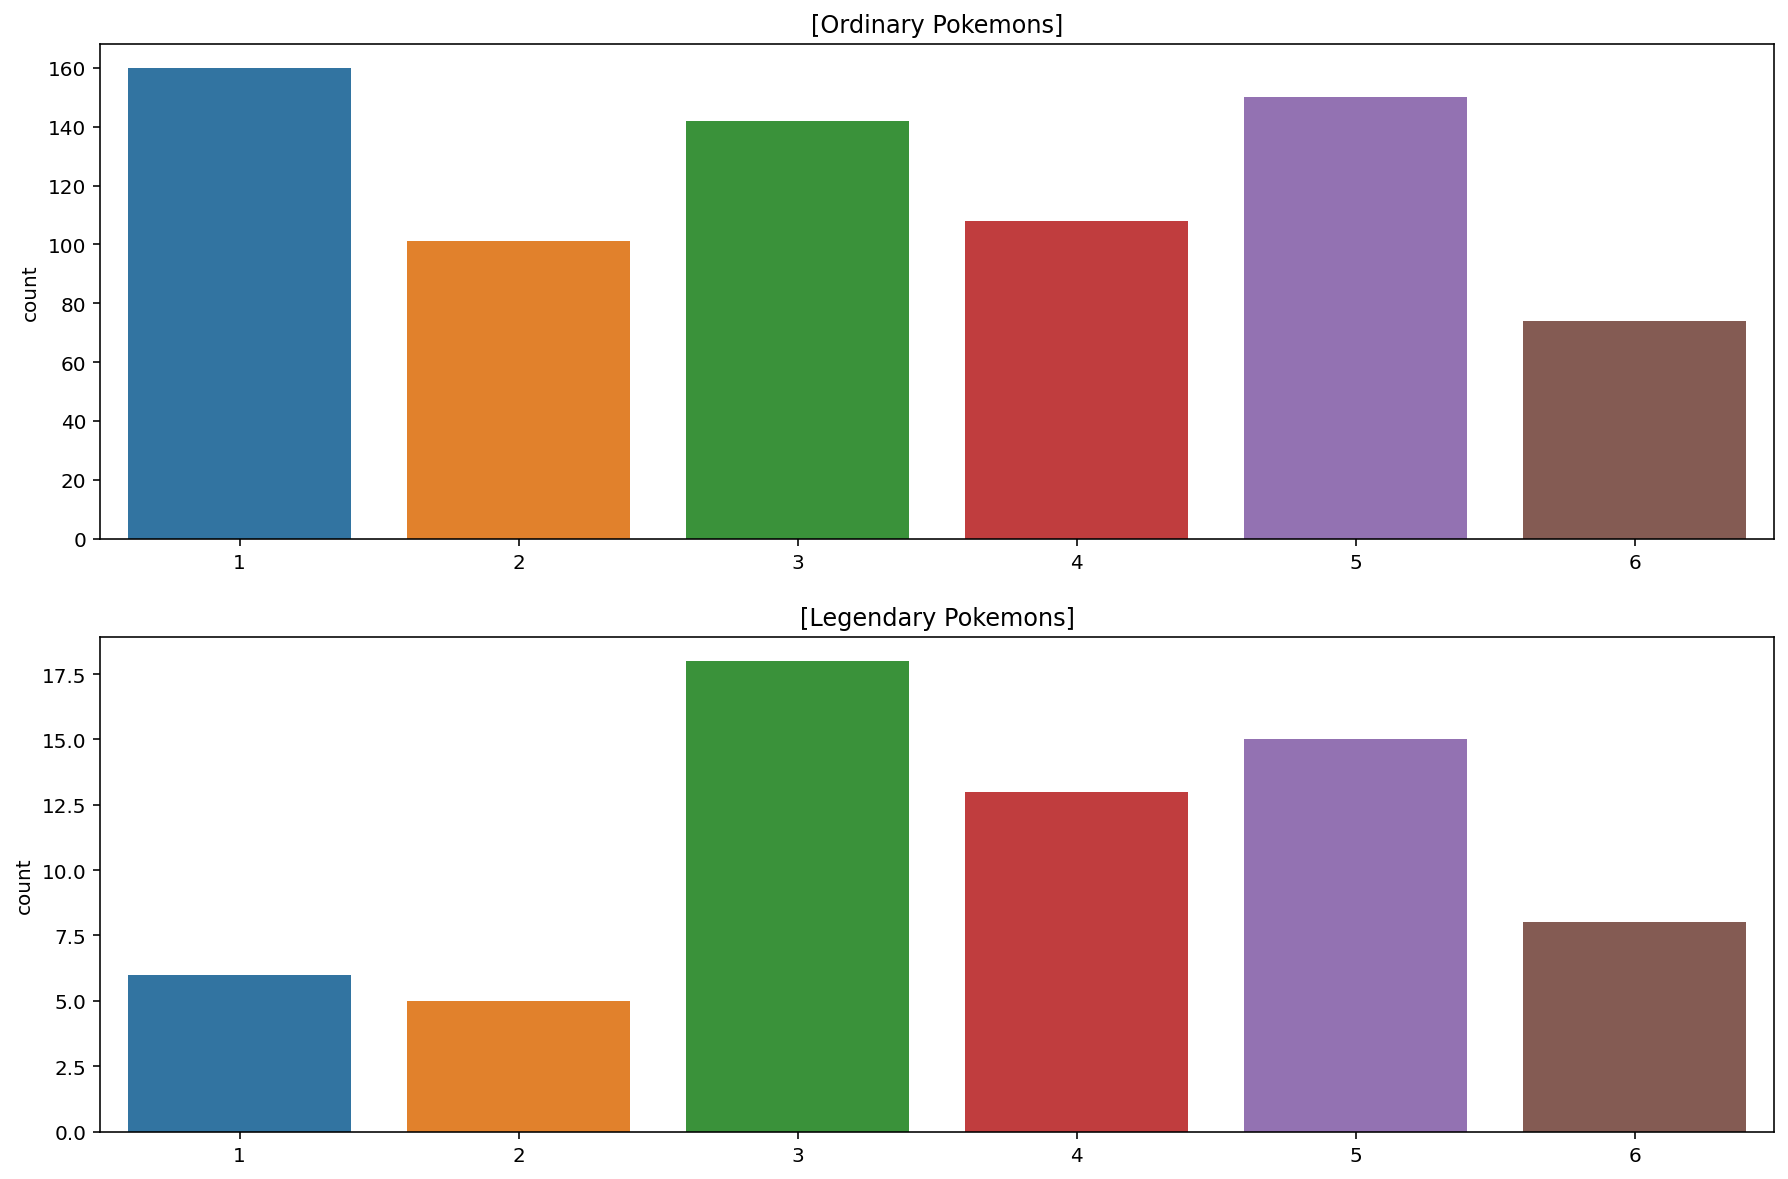

In [362]:
plt.figure(figsize=(15, 10)) 

plt.subplot(211)
sns.countplot(data=ordinary, x="Generation").set_xlabel('')
plt.title("[Ordinary Pokemons]")
plt.subplot(212)
sns.countplot(data=legendary, x="Generation").set_xlabel('')
plt.title("[Legendary Pokemons]")
plt.show()

## 2-2. 전설의 포켓몬 vs 일반 포켓몬 차이점(비교)
- 목표 : 전설의 포켓몬을 일반 포켓몬에서 분류해 내는 것
### 2-2-(1) Total값
    - 전설의 포켓몬의 Total 값

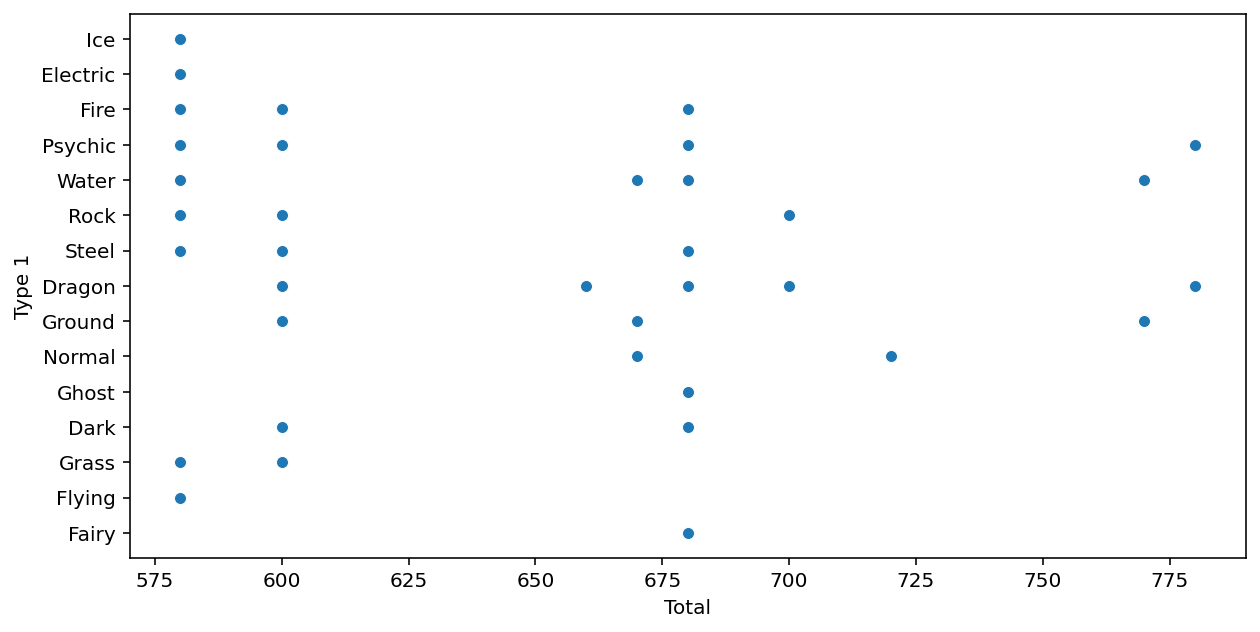

In [363]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

sns.scatterplot(data=legendary, y="Type 1", x="Total")
plt.show()

In [364]:
# 전설의 포켓몬들의 Total 값들이 특정한 값에 몰려있다. 
# ex) 580, 600, 680, ...

In [365]:
# 실제로 전설의 포켓몬이 가지는 Total값들의 집합을 확인 -> 9가지 값이 존재

print(sorted(list(set(legendary["Total"]))))

[580, 600, 660, 670, 680, 700, 720, 770, 780]


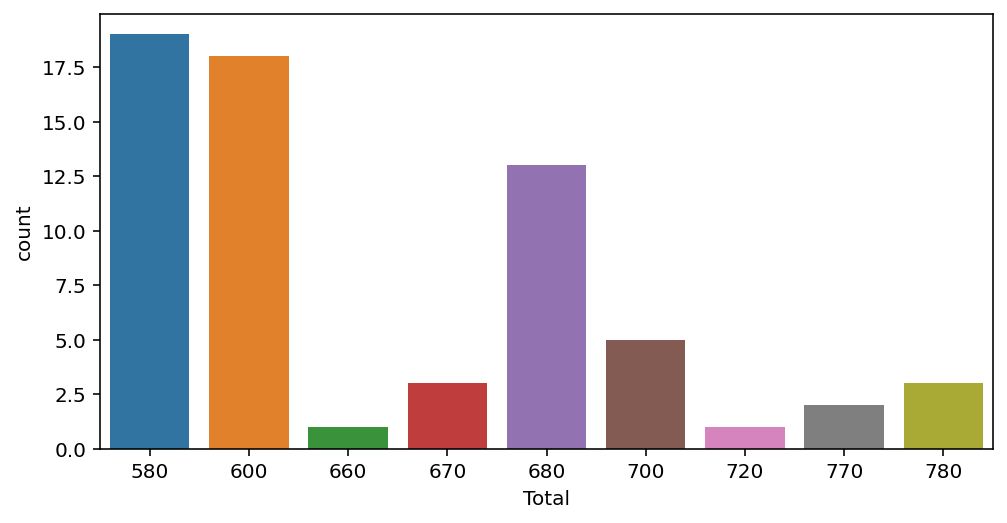

In [366]:
# 전설의 포켓몬이 가지는 각 Total값에 대한 포켓몬 수를 확인

fig, ax = plt.subplots()
fig.set_size_inches(8, 4)

sns.countplot(data=legendary, x="Total")
plt.show()

In [367]:
# 총 65마리의 전설의 포켓몬이 9개의 Total값만 가진다는 것은,
round(65 / 9, 2)

# 약 7.22마리 끼리는 같은 Total 스탯 값을 가진다는 의미와 같다.

7.22

    - ordinary 포켓몬의 Total 값 비교

In [368]:
# Q. ordinary 포켓몬의 'Total' 값 집합을 확인  -> 195개
print(sorted(list(set(ordinary["Total"]))))

len(sorted(list(set(ordinary["Total"]))))

[180, 190, 194, 195, 198, 200, 205, 210, 213, 215, 218, 220, 224, 236, 237, 240, 244, 245, 250, 251, 253, 255, 260, 262, 263, 264, 265, 266, 269, 270, 273, 275, 278, 280, 281, 285, 288, 289, 290, 292, 294, 295, 299, 300, 302, 303, 304, 305, 306, 307, 308, 309, 310, 313, 314, 315, 316, 318, 319, 320, 323, 325, 328, 329, 330, 334, 335, 336, 340, 341, 345, 348, 349, 350, 351, 352, 355, 358, 360, 362, 363, 365, 369, 370, 371, 375, 380, 382, 384, 385, 390, 395, 400, 401, 405, 409, 410, 411, 413, 414, 415, 418, 420, 423, 424, 425, 428, 430, 431, 435, 438, 440, 442, 445, 446, 448, 450, 452, 454, 455, 456, 458, 460, 461, 462, 464, 465, 466, 467, 468, 470, 471, 472, 473, 474, 475, 479, 480, 481, 482, 483, 484, 485, 487, 488, 489, 490, 494, 495, 497, 498, 499, 500, 505, 507, 508, 509, 510, 514, 515, 518, 519, 520, 521, 523, 525, 528, 530, 531, 534, 535, 540, 545, 550, 552, 555, 560, 565, 567, 575, 579, 580, 590, 594, 600, 610, 615, 618, 625, 630, 634, 635, 640, 670, 700]


195

In [369]:
# 일반 포켓몬은 총 195가지의 Total 속성값을 가지고, 전체 일반 포켓몬은 (800 - 65), 즉 735마리이므로,
round(735 / 195, 2)

# 약 3.77마리만 같은 Total 스탯 값을 가진다.

3.77

- Total 값의 다양성은 일반 195개, 전설 65개로 일반 포켓몬이 2배 넘는다.
    - -> 전설의 포켓몬의 total값은 다양하지 않다.
    - -> **한 포켓몬의 Total 속성값이 전설의 포켓몬의 값들 집합에 포함되는지의 여부**는 전설의 포켓몬임을 판별(결정)하는 데에 영향을 미친다.
- 전설의 포켓몬의 Total값 중에는 일반 포켓몬이 가지지 못하는 Total값이 존재 (ex. 680, 700, 720, 770, 780)
    - -> Total 값은 전설의 포켓몬 여부를 결정할 때 값의 크기로도 영향을 미칠 수 있다.
<br><br>
**즉, Total값은 legendary인지 아닌지를 예측하는 데에 중요한 컬럼일 것이라는 결론*

### 2-2-(2) 이름
전설의 포켓몬들의 이름을 보면, 특정 단어가 들어가 있는 이름, 또는 긴 이름을 가진 경우가 많음을 확인할 수 있다. <br>

**특정 단어가 들어가 있는 이름**

In [370]:
# 특정 단어가 들어가 있는 이름이 많은지? 확인 - pd.concat로 합치기

n1, n2, n3, n4, n5 = legendary[3:6], legendary[14:24], legendary[25:29], legendary[46:50], legendary[52:57]
names = pd.concat([n1, n2, n3, n4, n5]).reset_index(drop=True)
names

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True
1,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,106,190,100,154,100,130,1,True
2,150,MewtwoMega Mewtwo Y,Psychic,NaN,780,106,150,70,194,120,140,1,True
3,380,Latias,Dragon,Psychic,600,80,80,90,110,130,110,3,True
4,380,LatiasMega Latias,Dragon,Psychic,700,80,100,120,140,150,110,3,True
5,381,Latios,Dragon,Psychic,600,80,90,80,130,110,110,3,True
6,381,LatiosMega Latios,Dragon,Psychic,700,80,130,100,160,120,110,3,True
7,382,Kyogre,Water,NaN,670,100,100,90,150,140,90,3,True
8,382,KyogrePrimal Kyogre,Water,NaN,770,100,150,90,180,160,90,3,True
9,383,Groudon,Ground,NaN,670,100,150,140,100,90,90,3,True


In [371]:
# "MewTwo", "Latias", "Latios", "Kyogre", "Groudon", "Rayquaza", "Kyurem" 등의 포켓몬은 비슷한 이름을 가진 포켓몬들이 많음

**또는, 이름에 forme가 들어가는 여러 가지 전설의 포켓몬이 있는 경우도 존재**

In [372]:
formes = names[13:23]
formes

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
13,386,DeoxysNormal Forme,Psychic,NaN,600,50,150,50,150,50,150,3,True
14,386,DeoxysAttack Forme,Psychic,NaN,600,50,180,20,180,20,150,3,True
15,386,DeoxysDefense Forme,Psychic,NaN,600,50,70,160,70,160,90,3,True
16,386,DeoxysSpeed Forme,Psychic,NaN,600,50,95,90,95,90,180,3,True
17,641,TornadusIncarnate Forme,Flying,NaN,580,79,115,70,125,80,111,5,True
18,641,TornadusTherian Forme,Flying,NaN,580,79,100,80,110,90,121,5,True
19,642,ThundurusIncarnate Forme,Electric,Flying,580,79,115,70,125,80,111,5,True
20,642,ThundurusTherian Forme,Electric,Flying,580,79,105,70,145,80,101,5,True
21,645,LandorusIncarnate Forme,Ground,Flying,600,89,125,90,115,80,101,5,True
22,645,LandorusTherian Forme,Ground,Flying,600,89,145,90,105,80,91,5,True


**긴 이름** <br>
- 데이터셋에 이름 길이 컬럼을 생성해서 비교
- legendary와 ordinary 각각에 모두 "name_count"라는 이름의 길이를 나타내는 컬럼을 만들기
- 파이썬 람다(lambda) 기능을 사용해 행마다 이름의 길이를 구하고, 이를 "name_count" 칼럼에 넣어주기

In [373]:
# legendary 포켓몬 데이터에 'name_count' 값을 추가
legendary["name_count"] = legendary["Name"].apply(lambda i: len(i))    
legendary.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count
0,144,Articuno,Ice,Flying,580,90,85,100,95,125,85,1,True,8
1,145,Zapdos,Electric,Flying,580,90,90,85,125,90,100,1,True,6
2,146,Moltres,Fire,Flying,580,90,100,90,125,85,90,1,True,7
3,150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True,6
4,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,106,190,100,154,100,130,1,True,19


In [374]:
# Q. ordinary 포켓몬의 데이터에도 'name_count' 값을 추가
ordinary["name_count"] = ordinary["Name"].apply(lambda i: len(i))
ordinary.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10


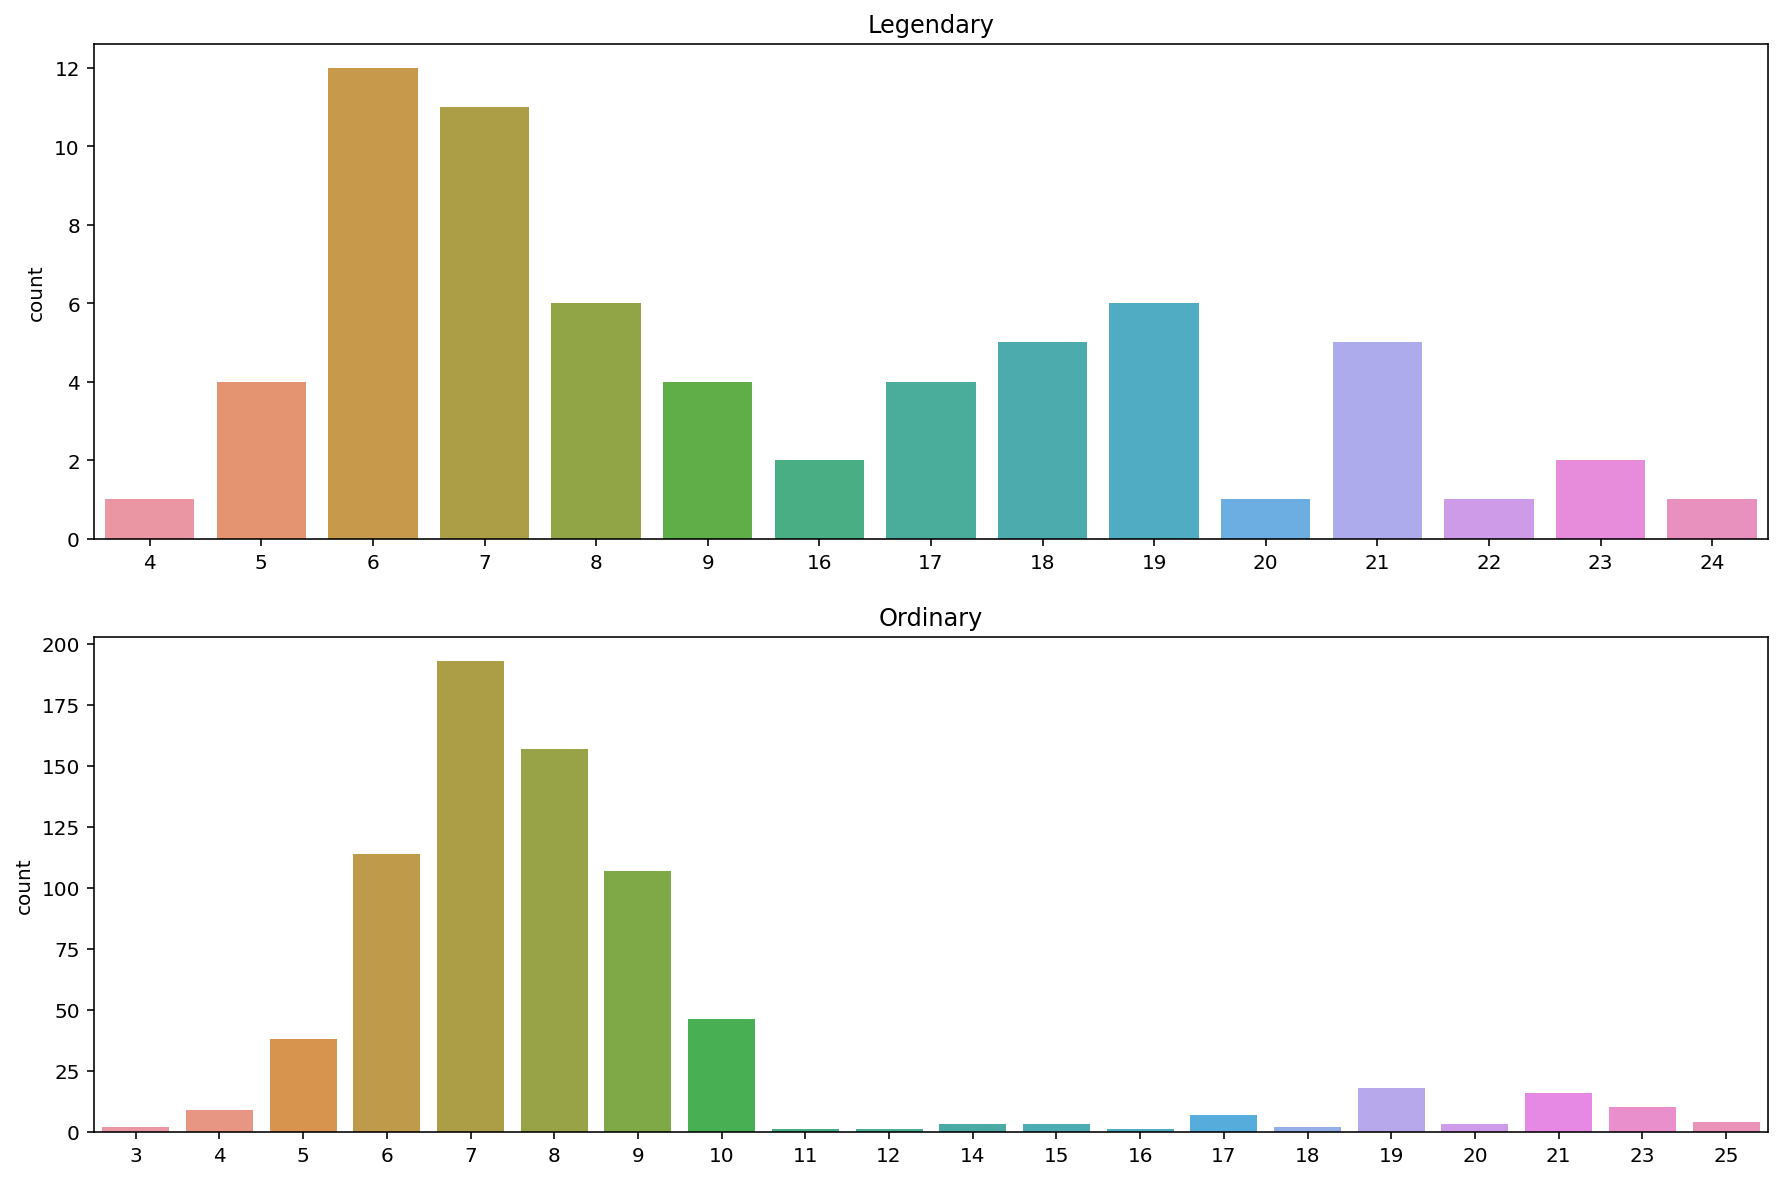

In [375]:
# name_count 컬럼은 어떤 특징을 갖게 될까? -> 그래프로 확인

plt.figure(figsize=(15, 10))

plt.subplot(211)
sns.countplot(data=legendary, x="name_count").set_xlabel('')
plt.title("Legendary")
plt.subplot(212)
sns.countplot(data=ordinary, x="name_count").set_xlabel('')
plt.title("Ordinary")
plt.show()

전설의 포켓몬은 16 이상의 긴 이름을 가진 포켓몬이 많은 반면, 일반 포켓몬은 10 이상의 길이를 가지는 이름의 빈도가 아주 낮다.

- 전설의 포켓몬의 이름이 10 이상일 확률은?

In [376]:
print(round(len(legendary[legendary["name_count"] > 9]) / len(legendary) * 100, 2), "%")

41.54 %


- 일반 포켓몬의 이름이 10 이상일 확률은?

In [377]:
print(round(len(ordinary[ordinary["name_count"] > 9]) / len(ordinary) * 100, 2), "%")

15.65 %


-> 전설의 포켓몬의 이름이 10 이상일 확률은 41% 를 넘는 반면에, 일반 포켓몬의 이름이 10 이상일 확률은 약 16% 밖에 안됨 <br>
**아주 큰 차이이므로 legendary인지 아닌지를 구분하는 데에 큰 의미가 있다!**
<br>
- 시사점
    - 만약 "Latios"가 전설의 포켓몬이라면, "%%% Latios" 또한 전설의 포켓몬이다!
    - 적어도 전설의 포켓몬에서 높은 빈도를 보이는 이름들의 모임이 존재한다! (ex. forme)
    - 전설의 포켓몬은 긴 이름을 가졌을 확률이 높다!

## 3. 데이터 전처리
1. 이름의 길이 : name_count 컬럼을 생성 후 길이가 10을 넘는지 아닌지에 대한 categorical 컬럼을 생성 -> True or False
2. 토큰 추출 : legendary 포켓몬에서 많이 등장하는 토큰을 추려내고 토큰 포함 여부를 원-핫 인코딩(One-Hot Encoding)으로 처리

### 3-(1) 이름의 길이가 10 이상인가?

In [378]:
pokemon["name_count"] = pokemon["Name"].apply(lambda i: len(i))
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10


In [379]:
# 이름의 길이가 10 이상이면 True, 미만이면 False
pokemon["long_name"] = pokemon["name_count"] >= 10
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21,True
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10,True


### 3-(2) 이름에 자주 쓰이는 토큰 추출

- 이름은 총 4가지 타입
1. 한 단어면 ex. Venusaur
2. 두 단어이고, 앞 단어는 두 개의 대문자를 가지며 대문자를 기준으로 두 부분으로 나뉘는 경우 ex. VenusaurMega Venusaur
3. 이름은 두 단어이고, 맨 뒤에 X, Y로 성별을 표시하는 경우 ex. CharizardMega Charizard X
4. 알파벳이 아닌 문자를 포함하는 경우 ex. Zygarde50% Forme

**이름에 알파벳이 아닌 문자가 들어간 경우 전처리하기** <br>
- 어떤 문자열이 알파벳으로만 이루어져 있는지를 확인하고 싶을 때는 isalpha() 함수를 사용
    - 주의할 점은 이름에 띄어쓰기가 있는 경우에도 isalpha() = False로 처리된다는 점
    - 알파벳 체크를 위해 띄어쓰기가 없는 컬럼을 따로 만들어준 후, 띄어쓰기를 빈칸으로 처리해서 확인

In [380]:
# 띄어쓰기 없는 컬럼 만들기 Name_nospace
pokemon["Name_nospace"] = pokemon["Name"].apply(lambda i: i.replace(" ", ""))
pokemon.tail()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True,7,False,Diancie
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True,19,True,DiancieMegaDiancie
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True,19,True,HoopaHoopaConfined
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True,18,True,HoopaHoopaUnbound
799,721,Volcanion,Fire,Water,600,80,110,120,130,90,70,6,True,9,False,Volcanion


In [381]:
# isalpha() 함수를 이용해 이름이 알파벳으로만 이루어졌는지 확인
pokemon["name_isalpha"] = pokemon["Name_nospace"].apply(lambda i: i.isalpha())
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9,False,Bulbasaur,True
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7,False,Ivysaur,True
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8,False,Venusaur,True
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21,True,VenusaurMegaVenusaur,True
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10,True,Charmander,True


In [382]:
# 알파벳이 아닌 다른 문자가 이름에 포함된 것이 있는지 체크

print(pokemon[pokemon["name_isalpha"] == False].shape)
pokemon[pokemon["name_isalpha"] == False]

(9, 17)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha
34,29,Nidoran♀,Poison,NaN,275,55,47,52,40,40,41,1,False,8,False,Nidoran♀,False
37,32,Nidoran♂,Poison,NaN,273,46,57,40,40,40,50,1,False,8,False,Nidoran♂,False
90,83,Farfetch'd,Normal,Flying,352,52,65,55,58,62,60,1,False,10,True,Farfetch'd,False
131,122,Mr. Mime,Psychic,Fairy,460,40,45,65,100,120,90,1,False,8,False,Mr.Mime,False
252,233,Porygon2,Normal,NaN,515,85,80,90,105,95,60,2,False,8,False,Porygon2,False
270,250,Ho-oh,Fire,Flying,680,106,130,90,110,154,90,2,True,5,False,Ho-oh,False
487,439,Mime Jr.,Psychic,Fairy,310,20,25,45,70,90,60,4,False,8,False,MimeJr.,False
525,474,Porygon-Z,Normal,NaN,535,85,80,70,135,75,90,4,False,9,False,Porygon-Z,False
794,718,Zygarde50% Forme,Dragon,Ground,600,108,100,121,81,95,95,6,True,16,True,Zygarde50%Forme,False


In [383]:
# 문자열을 원하는 문자열로 직접 바꾸기 - pandas의 replace 함수
pokemon = pokemon.replace(to_replace="Nidoran♀", value="Nidoran X")
pokemon = pokemon.replace(to_replace="Nidoran♂", value="Nidoran Y")
pokemon = pokemon.replace(to_replace="Farfetch'd", value="Farfetchd")
pokemon = pokemon.replace(to_replace="Mr. Mime", value="Mr Mime")
pokemon = pokemon.replace(to_replace="Porygon2", value="Porygon Two")
pokemon = pokemon.replace(to_replace="Ho-oh", value="Ho Oh")
pokemon = pokemon.replace(to_replace="Mime Jr.", value="Mime Jr")
pokemon = pokemon.replace(to_replace="Porygon-Z", value="Porygon Z")
pokemon = pokemon.replace(to_replace="Zygarde50% Forme", value="Zygarde Forme")

pokemon.loc[[34, 37, 90, 131, 252, 270, 487, 525, 794]]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha
34,29,Nidoran X,Poison,NaN,275,55,47,52,40,40,41,1,False,8,False,Nidoran X,False
37,32,Nidoran Y,Poison,NaN,273,46,57,40,40,40,50,1,False,8,False,Nidoran Y,False
90,83,Farfetchd,Normal,Flying,352,52,65,55,58,62,60,1,False,10,True,Farfetchd,False
131,122,Mr Mime,Psychic,Fairy,460,40,45,65,100,120,90,1,False,8,False,Mr.Mime,False
252,233,Porygon Two,Normal,NaN,515,85,80,90,105,95,60,2,False,8,False,Porygon Two,False
270,250,Ho Oh,Fire,Flying,680,106,130,90,110,154,90,2,True,5,False,Ho Oh,False
487,439,Mime Jr,Psychic,Fairy,310,20,25,45,70,90,60,4,False,8,False,MimeJr.,False
525,474,Porygon Z,Normal,NaN,535,85,80,70,135,75,90,4,False,9,False,Porygon Z,False
794,718,Zygarde Forme,Dragon,Ground,600,108,100,121,81,95,95,6,True,16,True,Zygarde50%Forme,False


In [384]:
# Q. 바꿔준 'Name' 컬럼으로 'Name_nospace'를 만들고, 다시 isalpha()로 체크해보기
pokemon["Name_nospace"] = pokemon["Name"].apply(lambda i: i.replace(" ", ""))
pokemon.tail()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True,7,False,Diancie,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True,19,True,DiancieMegaDiancie,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True,19,True,HoopaHoopaConfined,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True,18,True,HoopaHoopaUnbound,True
799,721,Volcanion,Fire,Water,600,80,110,120,130,90,70,6,True,9,False,Volcanion,True


In [385]:
pokemon["name_isalpha"] = pokemon["Name_nospace"].apply(lambda i: i.isalpha())
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,9,False,Bulbasaur,True
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7,False,Ivysaur,True
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,8,False,Venusaur,True
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,21,True,VenusaurMegaVenusaur,True
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,10,True,Charmander,True


In [386]:
print(pokemon[pokemon["name_isalpha"] == False].shape)
pokemon[pokemon["name_isalpha"] == False]

(0, 17)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,name_count,long_name,Name_nospace,name_isalpha


**이름을 띄어쓰기 & 대문자 기준으로 분리해 토큰화하기**
- 이제 모든 이름은 세 가지 타입으로 나뉘므로 토큰화(tokenizing) 가능
- 이름에 있는 토큰을 추출하기 위해 이름을 토큰화 (모든 토큰으로 분리) 할 수 있는 함수를 생성
- 정규표현식(RegEx: Regular Expression) : 문자열을 처리하는 방법의 하나로, 특정한 조건을 만족하는 문자를 검색하거나 치환하는 등의 작업을 하고 싶을 때 간편하게 처리할 수 있게 해주는 도구
- 정규표현식은 re라는 패키지에서 지원

**Q. "a.b"는 무엇을 의미하나요?** <br>
"a + 모든_문자 + b"

In [387]:
# 정규식 re패키지
import re

In [388]:
name = "CharizardMega Charizard X"

In [389]:
name_split = name.split(" ")
name_split

['CharizardMega', 'Charizard', 'X']

In [390]:
# 여기서 한 가지 더 해야 하는 일은 맨 처음 요소인 CharizardMega 를 Charizard와 Mega로 나누는 것
# -> 대문자를 기준으로 분리하기
# name_split 리스트 안에 있는 첫 번째 요소를 쪼개고 싶으므로 temp에 저장

temp = name_split[0]
temp

'CharizardMega'

In [391]:
# 대문자로 시작해서 소문자로 끝나는 토큰들로 분리하는 패턴
tokens = re.findall('[A-Z][a-z]*', temp)
tokens

['Charizard', 'Mega']

- [A-Z] : A부터 Z까지의 대문자 중 한 가지로 시작하고,
- [a-z] : 그 뒤에 a부터 z까지의 소문자 중 한 가지가 붙는데,
- 별표 : 그 소문자의 개수는 하나 이상인 패턴 (*는 정규표현식 중에서 "반복"을 나타내는 기호)
- findall은 패턴([A-Z][a-z]*)과 매치되는 모든 값을 찾아 리스트로 리턴한다.

In [392]:
# 반복문으로 합치면 한 개의 이름을 이루고 있는 모든 토큰을 tokens에 모아둘 수 있다.

tokens = []
for part_name in name_split:
    a = re.findall('[A-Z][a-z]*', part_name)
    tokens.extend(a)
tokens

['Charizard', 'Mega', 'Charizard', 'X']

In [393]:
# 토큰화 과정을 모든 이름에 적용시킬 수 있도록 함수를 만들어서 전체 데이터셋에 적용

def tokenize(name):
    name_split = name.split(" ")

    tokens = []
    for part_name in name_split:
        a = re.findall('[A-Z][a-z]*', part_name)
        tokens.extend(a)
        
    return np.array(tokens)

In [394]:
# 토큰화 함수 테스트
name = "CharizardMega Charizard X"
tokenize(name)

array(['Charizard', 'Mega', 'Charizard', 'X'], dtype='<U9')

- tokenize(name)라는 코드로 이름을 모두 토큰화 가능! <br>
- -> 전설의 포켓몬 데이터셋에 적용 -> 전설의 포켓몬의 이름에 사용된 토큰 모으기

In [395]:
# 전설의 포켓몬의 이름에 사용된 토큰
all_tokens = list(legendary["Name"].apply(tokenize).values)

token_set = []
for token in all_tokens:
    token_set.extend(token)

print(len(set(token_set)))    # 토큰의 총 개수
print(token_set)

65
['Articuno', 'Zapdos', 'Moltres', 'Mewtwo', 'Mewtwo', 'Mega', 'Mewtwo', 'X', 'Mewtwo', 'Mega', 'Mewtwo', 'Y', 'Raikou', 'Entei', 'Suicune', 'Lugia', 'Ho', 'Regirock', 'Regice', 'Registeel', 'Latias', 'Latias', 'Mega', 'Latias', 'Latios', 'Latios', 'Mega', 'Latios', 'Kyogre', 'Kyogre', 'Primal', 'Kyogre', 'Groudon', 'Groudon', 'Primal', 'Groudon', 'Rayquaza', 'Rayquaza', 'Mega', 'Rayquaza', 'Jirachi', 'Deoxys', 'Normal', 'Forme', 'Deoxys', 'Attack', 'Forme', 'Deoxys', 'Defense', 'Forme', 'Deoxys', 'Speed', 'Forme', 'Uxie', 'Mesprit', 'Azelf', 'Dialga', 'Palkia', 'Heatran', 'Regigigas', 'Giratina', 'Altered', 'Forme', 'Giratina', 'Origin', 'Forme', 'Darkrai', 'Shaymin', 'Land', 'Forme', 'Shaymin', 'Sky', 'Forme', 'Arceus', 'Victini', 'Cobalion', 'Terrakion', 'Virizion', 'Tornadus', 'Incarnate', 'Forme', 'Tornadus', 'Therian', 'Forme', 'Thundurus', 'Incarnate', 'Forme', 'Thundurus', 'Therian', 'Forme', 'Reshiram', 'Zekrom', 'Landorus', 'Incarnate', 'Forme', 'Landorus', 'Therian', 'Form

- 많이 사용된 토큰을 추출
    - list 또는 set의 자료형에서 각 요소의 개수를 다루고 싶을 때에는 파이썬의 collection이라는 패키지를 사용
    - collection은 순서가 있는 딕셔너리인 OrderedDict, 요소의 개수를 카운트하는 Counter 등 여러 다양한 모듈을 제공

---
- [참고] Counter 객체 활용법

In [396]:
# Counter 객체 활용 예시
from collections import Counter
my_list = ['a', 'd', 'c', 'a', 'b']
my_counter = Counter(my_list)
my_counter

# -> 각 요소 별 개수를 담은 딕셔너리 형태를 반환

Counter({'a': 2, 'd': 1, 'c': 1, 'b': 1})

In [397]:
from collections import Counter
a = [1, 1, 0, 0, 0, 1, 1, 2, 3]
Counter(a)

# -> 각 요소가 몇 개인지를 담은 튜플 리스트를 반환

Counter({1: 4, 0: 3, 2: 1, 3: 1})

In [398]:
# most_common : 가장 많은 요소와 등장 횟수가 무엇인지를 정렬

Counter(a).most_common()

[(1, 4), (0, 3), (2, 1), (3, 1)]

---

In [399]:
# token_set에서 어떤 토큰이 가장 많이 쓰였는지 확인 __10개 추려보기

most_common = Counter(token_set).most_common(10)
most_common

[('Forme', 15),
 ('Mega', 6),
 ('Mewtwo', 5),
 ('Kyurem', 5),
 ('Deoxys', 4),
 ('Hoopa', 4),
 ('Latias', 3),
 ('Latios', 3),
 ('Kyogre', 3),
 ('Groudon', 3)]

In [400]:
# 전설의 포켓몬 이름에 등장하는 토큰이 포켓몬의 이름에 있는지의 여부를 나타내는 컬럼 만들기
for token, _ in most_common:
    pokemon[f"{token}"] = pokemon["Name"].str.contains(token)

pokemon.head(10)

# str.contains 함수 : Pandas에서 문자열 데이터셋에 특정 구문이 포함되어 있는지 여부 확인하는 함수
# pokemon[token] = ... 형식으로 사용하면 뒤에서 warning이 발생

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,...,Forme,Mega,Mewtwo,Kyurem,Deoxys,Hoopa,Latias,Latios,Kyogre,Groudon
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,...,False,False,False,False,False,False,False,False,False,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,...,False,False,False,False,False,False,False,False,False,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,...,False,False,False,False,False,False,False,False,False,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,...,False,True,False,False,False,False,False,False,False,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,...,False,False,False,False,False,False,False,False,False,False
5,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,...,False,False,False,False,False,False,False,False,False,False
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,...,False,False,False,False,False,False,False,False,False,False
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,...,False,True,False,False,False,False,False,False,False,False
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,...,False,True,False,False,False,False,False,False,False,False
9,7,Squirtle,Water,NaN,314,44,48,65,50,64,...,False,False,False,False,False,False,False,False,False,False


- 많이 등장하는 토큰의 컬럼 값이 True로 표시되면 그 포켓몬은 전설의 포켓몬일 확률이 높다고 판단할 수 있다.
- 여기까지가 머신러닝 모델 학습을 위해 문자열을 bool형태로 변환한 과정

### 3-(3) Type1 & 2! 범주형 데이터 전처리하기
범주형 데이터 전처리 규칙
- 18가지의 모든 Type를 모두 원-핫 인코딩(One-Hot Encoding)합니다.
    - 18개의 모든 Type에 대한 컬럼을 만들고, 그 Type에 해당하면 True를, 아니면 False를 넣기
- 두 가지 속성을 가진 포켓몬은 두 가지 Type에 해당하는 자리에서 1 값을 가지도록 합니다.

In [401]:
print(types)

['Fighting', 'Psychic', 'Dark', 'Ground', 'Ghost', 'Water', 'Poison', 'Electric', 'Bug', 'Normal', 'Dragon', 'Rock', 'Flying', 'Steel', 'Grass', 'Fire', 'Fairy', 'Ice']


In [402]:
for t in types:
    pokemon[t] = (pokemon["Type 1"] == t) | (pokemon["Type 2"] == t)
    
pokemon[[["Type 1", "Type 2"] + types][0]].head()

,Type 1,Type 2,Fighting,Psychic,Dark,Ground,Ghost,Water,Poison,Electric,Bug,Normal,Dragon,Rock,Flying,Steel,Grass,Fire,Fairy,Ice
0,Grass,Poison,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False
1,Grass,Poison,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False
2,Grass,Poison,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False
3,Grass,Poison,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False
4,Fire,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


## 4. 모델 학습
### 4-(1) 가장 기본 데이터로 만드는 베이스라인
- 새로 생성한 컬럼들을 제외한, 가장 기본으로 처음부터 있었던 컬럼들만 사용하여 베이스라인 모델 만들기
- 베이스라인 모델은 성능 하한선이 됨 (새롭게 모델을 만들 때)

In [403]:
# 원본 데이터
print(original_data.shape)
original_data.head()

(800, 13)


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


**문자열 데이터 삭제**
- 하기 컬럼 삭제
    - 샾 : 의미없는 컬럼
    - 문자열 데이터 : Name, Type 1, Type 2
    - target 데이터 : Legendary

In [404]:
# 컬럼 확인
original_data.columns

Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

In [405]:
# 문자열 데이터 삭제
features = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']

**X, y 에 데이터 저장**

In [406]:
# target 데이터인 Legendary를 변수에 저장하기
target = 'Legendary'

In [407]:
# Q. 'original_data'에서 'features' 컬럼에 해당하는 데이터를 변수 'X'에 저장 - 모델에 바로 넣어줄 수 있도록
X = original_data[features]
print(X.shape)
X.head()

(800, 8)


,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
0,318,45,49,49,65,65,45,1
1,405,60,62,63,80,80,60,1
2,525,80,82,83,100,100,80,1
3,625,80,100,123,122,120,80,1
4,309,39,52,43,60,50,65,1


In [408]:
# Q. 'target' 컬럼의 데이터를 변수 'y'에 저장
y = original_data[target]
print(y.shape)
y.head()

(800,)


0    False
1    False
2    False
3    False
4    False
Name: Legendary, dtype: bool

**훈련 데이터와 학습 데이터로 분리**

In [409]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(640, 8) (640,)
(160, 8) (160,)


### 4-(2) 의사 결정 트리 모델 학습시키기
- 분류 모델인 의사 결정 트리(decision tree) 를 사용

In [410]:
# 라이브러리 불러오기 및 테스트
from sklearn.tree import DecisionTreeClassifier
print('슝=3')

슝=3


In [411]:
# 의사결정트리 변수에 담기
model = DecisionTreeClassifier(random_state=25)
model

DecisionTreeClassifier(random_state=25)

In [412]:
# 모델 학습 및 예측
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('슝=3')

슝=3


In [413]:
# 예측값인 y_pred가 실제 정답인 y_test와 얼마나 비슷한지 채점
 # confusion_matrix 활용
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[144,   3],
       [  5,   8]])

- 위의 값은 TN, FP, FN, TP 순서 (왼쪽 위부터)
    - TN (True Negative) : 참 음성, 즉 일반 포켓몬을 일반 포켓몬이라고 알맞게 판단한 경우
    - FP (False Positive) : 거짓 양성, 즉 일반 포켓몬을 전설의 포켓몬이라고 잘못 판단한 경우
    - FN (False Negative) : 거짓 음성, 즉 전설의 포켓몬을 일반 포켓몬이라고 잘못 판단한 경우
    - TP (True Positive) : 참 양성, 즉 전설의 포켓몬을 전설의 포켓몬이라고 알맞게 판단한 경우
    
- 정확도는 95%
    - 계산 : (144+8)/160 = 0.95

In [414]:
len(legendary)

65

- 정확도를 온전히 신뢰할 수 있는가? -> NO!
    - 전체 800마리, 일반 735마리, 전설 65마리
    - 800마리를 모두 일반으로 예측하면 735/800*100 = 92%의 정확도를 달성
    - -> 따라서 이 데이터셋에서는 정확도로 모델 성능을 평가하는 것은 거의 의미가 없다.

In [415]:
# classification_report로 검증
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.98      0.97       147
        True       0.73      0.62      0.67        13

    accuracy                           0.95       160
   macro avg       0.85      0.80      0.82       160
weighted avg       0.95      0.95      0.95       160



- recall값 즉 재현율이 0.62로 낮음 (재현율 = TP / (TP + FN))
    - -> FN이 높다는 의미로, 양성 데이터를 잘 잡아내지 못함

## 4-(3) 피쳐 엔지니어링 데이터로 학습

In [416]:
print(len(pokemon.columns))
print(pokemon.columns)

45
Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary', 'name_count',
       'long_name', 'Name_nospace', 'name_isalpha', 'Forme', 'Mega', 'Mewtwo',
       'Kyurem', 'Deoxys', 'Hoopa', 'Latias', 'Latios', 'Kyogre', 'Groudon',
       'Fighting', 'Psychic', 'Dark', 'Ground', 'Ghost', 'Water', 'Poison',
       'Electric', 'Bug', 'Normal', 'Dragon', 'Rock', 'Flying', 'Steel',
       'Grass', 'Fire', 'Fairy', 'Ice'],
      dtype='object')


- 위의 컬럼 중 '#', 'Name', 'Type 1', 'Type 2', 'Name_nospace', 'name_isalpha', 'Legendary' 는 제외하고
- 사용할 컬럼만 features 변수에 저장

In [417]:
features = ['Total', 'HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 
            'name_count','long_name', 'Forme', 'Mega', 'Mewtwo','Deoxys', 'Kyurem', 'Latias', 'Latios',
            'Kyogre', 'Groudon', 'Hoopa','Poison', 'Ground', 'Flying', 'Normal', 'Water', 'Fire',
            'Electric','Rock', 'Dark', 'Fairy', 'Steel', 'Ghost', 'Psychic', 'Ice', 'Bug', 'Grass', 'Dragon', 'Fighting']

len(features)

38

In [418]:
# 타겟 변수에 저장
target = 'Legendary'
target

'Legendary'

In [419]:
# Q. 사용할 feature에 해당하는 데이터를 'X' 변수에 저장
X = pokemon[features]
print(X.shape)
X.head()

(800, 38)


,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,name_count,long_name,...,Dark,Fairy,Steel,Ghost,Psychic,Ice,Bug,Grass,Dragon,Fighting
0,318,45,49,49,65,65,45,1,9,False,...,False,False,False,False,False,False,False,True,False,False
1,405,60,62,63,80,80,60,1,7,False,...,False,False,False,False,False,False,False,True,False,False
2,525,80,82,83,100,100,80,1,8,False,...,False,False,False,False,False,False,False,True,False,False
3,625,80,100,123,122,120,80,1,21,True,...,False,False,False,False,False,False,False,True,False,False
4,309,39,52,43,60,50,65,1,10,True,...,False,False,False,False,False,False,False,False,False,False


In [420]:
# Q. 정답 데이터 'y'도 'target' 변수를 이용해 만들기
y = pokemon[target]
print(y.shape)
y.head()

(800,)


0    False
1    False
2    False
3    False
4    False
Name: Legendary, dtype: bool

In [421]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(640, 38) (640,)
(160, 38) (160,)


## 4-(4) 의사 결정 트리 모델 다시 학습시키기

In [422]:
model = DecisionTreeClassifier(random_state=25)
model

DecisionTreeClassifier(random_state=25)

In [423]:
# Q. train 데이터로 decision tree 모델을 학습시키고
# test 데이터로 모델의 예측 값을 얻어봅시다!
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=25)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

---
- 위의 모델 학습&예측 값을 얻는 코드에서 오류 발생
- 원인 : 4-(3) 피쳐 엔지니어링 데이터로 학습 -> target 변수를 이용해 y 만드는 코드에서의 오류
    - feature에 해당하는 데이터를 X 변수에 저장하는 코드를 복붙하여 사용하다가 X를 y로 수정하지 않은 실수로 인해 오류 발생
---

In [425]:
# confusion_matrix로 y_test 채점
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[141,   6],
       [  1,  12]])

In [426]:
# Q. classification report도 확인해봅시다!
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.96      0.98       147
        True       0.67      0.92      0.77        13

    accuracy                           0.96       160
   macro avg       0.83      0.94      0.87       160
weighted avg       0.97      0.96      0.96       160



### -> recall값이 0.62에서 0.92로 상승!

## 종합퀴즈 <br>
Q. 중복된 데이터를 제외한 데이터의 크기를 구하는 방법은 무엇이었을까요? <br>
(힌트: 포켓몬 이름에 중복이 없는지 확인할 때 이 방법을 썼습니다!) <br>

A. 데이터를 set으로 만들어준 뒤 len()함수로 길이를 확인<br><br>

Q. Seaborn 라이브러리의 여러 가지 그래프 중에서, 다음을 표현할 때 사용했던 plot의 종류를 복습해봅시다.<br>
① 포켓몬의 속성별로 몇 개의 데이터가 있는지 확인 <br>
② 각각의 스탯에 대해 전설 포켓몬과 일반 포켓몬 데이터 분포를 비교 <br>

A.  <br>
1번 : sns.countplot <br>
2번 : sns.scatterplot

---

# 회고 _ver.update
## KEEP
- 포켓몬 데이터 불러오기, EDA, 데이터 전처리, 모델 학습의 전반적인 과정을 이해하며 진행하였다.
- 오류 발생 시 정보 검색 및 여러 코드 실행 및 시도로 해결하였다. (전체 포켓몬에 대해 Total 값이 stats의 총합과 같은지 확인하는 부분)

## PROBLEM
- 의사결정 트리모델 학습 시 오류를 잡지 못함. (Expected 2D array, got 1D array instead:)
    - 완성하고 싶은 마음이 매우 간절한데 마감시간이 있다는 압박감 때문에 오류를 차분히 검토하지 못함.

## TRY
- 오류 해결방법을 찾아서 완성하기
     - 완성하여 업데이트함!
- 오류가 발생하더라도 해결할 수 있다는 믿음과 자신감을 가지고 차분히 살펴보는 것이 중요함을 더욱 절실히 느낌.
    - 퀘스트 종료 후 다시 보니 매우 간단히 해결되어 많이 아쉽고 속상하다ㅠㅠㅠ
- 보너스 퀘스트 및 기타 다른 데이터셋을 활용하여 모델 학습 부분 다양하게 적용해보는 연습하기 (눈 감고도 할 수 있을 정도로 손에 익도록!!)
- 어떤 데이터(피처)가 모델링에 영향을 미치는지 보는 눈을 기르자!

---

## reference
- 캐글 포켓몬 데이터셋 정보 : https://www.kaggle.com/datasets/abcsds/pokemon
- 판다스 데이터프레임 isna : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isna.html
- 판다스 데이터프레임 sum : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sum.html
- 판다스 데이터프레임 isalpha : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.isalpha.html
- 정규표현식 findall : https://wikidocs.net/4308#findall
- apply() 함수 : https://lifelong-education-dr-kim.tistory.com/entry/%EB%8D%B0%EC%9D%B4%ED%84%B0-%ED%94%84%EB%A0%88%EC%9E%84-%EA%B0%80%EA%B3%B5%EC%9D%84-%EC%9C%84%ED%95%9C-%ED%95%A8%EC%88%98-%EC%A0%81%EC%9A%A9-%EB%A9%94%EC%84%9C%EB%93%9C-apply-%EC%82%AC%EC%9A%A9%EB%B2%95
- Counter 객체 (요소의 개수를 카운트 _토큰셋에서 활용) : https://docs.python.org/3/library/collections.html#counter-objects
- 판다스 ==문법 (객체가 동일한지 비교) : https://pandas.pydata.org/docs/user_guide/basics.html#comparing-if-objects-are-equivalent
- Confusion Matrix : https://manisha-sirsat.blogspot.com/2019/04/confusion-matrix.html